In [1]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials
using SciMLBase
using QuadGK

In [2]:
outdict = readinput("Cu_C2_042925.rms")

[13:28:38] WARNING: not removing hydrogen atom without neighbors
[13:28:38] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [4]:
sitedensity = 2.943e-5; # Cu111 site density is 2.943e-9 mol/cm^2 or 2.943e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [5]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2 * 1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.943e-5 mol/m^2 * 3.6e-3 m^2 = 10.595e-8 mol

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 100.0e-6;
layer_thickness = 1e-3;
A_surf = V_res*36;
V_bl = A_surf*layer_thickness;
sites = sitedensity*A_surf;

initialcondsboundarylayer = Dict(["proton"=>C_proton,
                                  "CO2"=>C_co2,
                                  "H2"=>C_default,
                                  "O=CO"=>C_default,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -1.0 V vs. R.H.E. which equates to -1.414 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [6]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [7]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [8]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, layer_thickness);

In [9]:
interfaces = [inter, diffusionlayer];

In [10]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

 18.170376 seconds (76.38 M allocations: 4.721 GiB, 9.94% gc time, 99.85% compilation time: <1% of which was recompilation)


In [11]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-22,reltol=1e-8);

  9.619097 seconds (41.87 M allocations: 2.913 GiB, 8.45% gc time, 97.00% compilation time)


In [12]:
sol.t[end]

1000.0

In [13]:
sol.retcode

ReturnCode.Success = 1

In [14]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [15]:
concentrations(ssys.sims[1], 1e3)

39-element Vector{Float64}:
      0.0
      0.0
      0.0
      0.0
 903921.6805778637
      5.288671844749674
      0.0
      0.0
      9.52216702330371e-8
      0.0
      ⋮
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0

In [41]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    println(reservoirinterface.A);
    println(reservoirinterface.layer_thickness);
    println(sim.domain.diffusivity);
    println(cs);
    println(reservoirinterface.c);
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t);
    return intg./Vres
end

get_reservoir_concentration

In [42]:
flux_to_reservoir(ssys.sims[1],1e-12,diffusionlayer)

0.0036000000000000003
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.2139156476242518e-9, 1.122671285175347e-9, 1.6586845884779859e-9, 1.6586845884779859e-9, 1.14440221020022e-9, 1.0706139020926982e-9, 1.3343544679270026e-9, 1.5410849742783295e-9, 9.215925647738548e-10, 9.803948080706342e-10, 1.2139156476242518e-9, 1.0161703941206926e-9, 1.2950488917250014e-9, 1.1679197730034687e-9, 1.207073497764311e-9, 9.491783447442542e-10, 1.0270398396914194e-9, 1.0884930230558902e-9, 9.215925647738548e-10, 9.491783447442542e-10, 1.0270398396914194e-9, 9.215925647738548e-10, 9.803948080706342e-10, 9.491783447442542e-10, 9.928695644331783e-10, 1.0306102200591467e-9, 9.928695644331783e-10, 1.0459074498676583e-9, 1.2950488917250014e-9, 9.491783447442542e-10, 9.491783447442542e-10, 9.601126153434856e-10, 9.601126153434856e-10, 9.215925647738548e-10, 9.215925647738548e-10, 1.006004503291861e-9]
[0.0, 0.0, 0.0, 0.0, 2.7777777777777775e6, 27.777777777777775, 0.0, 0.0, 2.7777

39-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.011226672435587203
 1.6586786172134672e-7
 0.0
 0.0
 1.070613902092698e-15
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [43]:
res_cs = get_reservoir_concentration(ssys.sims[1],1e3,diffusionlayer,1.0)

0.0036000000000000003
0.001
[1.2791698254820209e-9, 1.8057956542205799e-9, 1.6715781069123858e-9, 1.2139156476242518e-9, 1.122671285175347e-9, 1.6586845884779859e-9, 1.6586845884779859e-9, 1.14440221020022e-9, 1.0706139020926982e-9, 1.3343544679270026e-9, 1.5410849742783295e-9, 9.215925647738548e-10, 9.803948080706342e-10, 1.2139156476242518e-9, 1.0161703941206926e-9, 1.2950488917250014e-9, 1.1679197730034687e-9, 1.207073497764311e-9, 9.491783447442542e-10, 1.0270398396914194e-9, 1.0884930230558902e-9, 9.215925647738548e-10, 9.491783447442542e-10, 1.0270398396914194e-9, 9.215925647738548e-10, 9.803948080706342e-10, 9.491783447442542e-10, 9.928695644331783e-10, 1.0306102200591467e-9, 9.928695644331783e-10, 1.0459074498676583e-9, 1.2950488917250014e-9, 9.491783447442542e-10, 9.491783447442542e-10, 9.601126153434856e-10, 9.601126153434856e-10, 9.215925647738548e-10, 9.215925647738548e-10, 1.006004503291861e-9]
[0.0, 0.0, 0.0, 0.0, 1.584578305202756e6, 12.120505926932633, 0.0, 0.0, 1.62635

39-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 6.745882029353241
 8.096078467470176e-5
 0.0
 0.0
 6.572019938559303e-13
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [19]:
sort(res_cs)

39-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 6.572019938559303e-13
 7.858513824957069e-13
 8.096078467470176e-5
 6.745882029353241

In [20]:
getfield.(ssys.sims[1].domain.phase.species,:name)

39-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "H2O"
 ⋮
 "C=C"
 "O=O"
 "C=C(O)O"
 "CC(=O)O"
 "COC"
 "CCO"
 "CC(O)O"
 "CCOO"
 "CC"

In [21]:
getfield.(ssys.sims[2].domain.phase.species,:name)

58-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "OCCO[Pt]"
 "OCOC[Pt]"
 "CCO.[Pt]"
 "COCO.[Pt]"
 "OCCO.[Pt]"
 "OCC[Pt]"
 "OCC(O)[Pt]"
 "O=CC(O)[Pt]"
 "O=C([Pt])C(O)[Pt]"

In [22]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [23]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

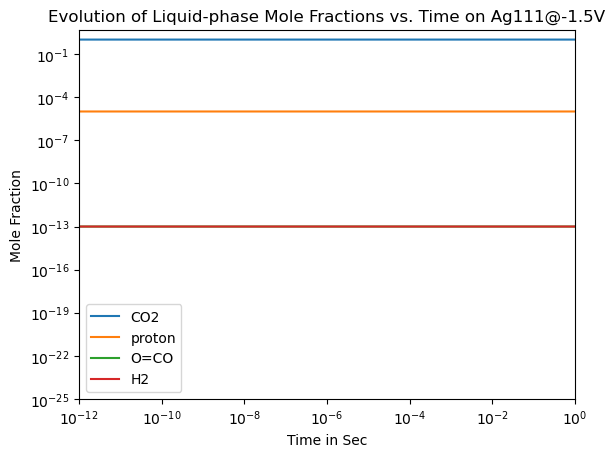

In [24]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

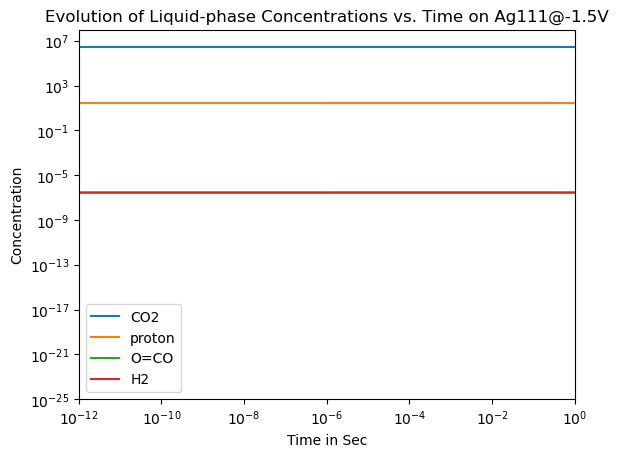

In [25]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 1e8)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

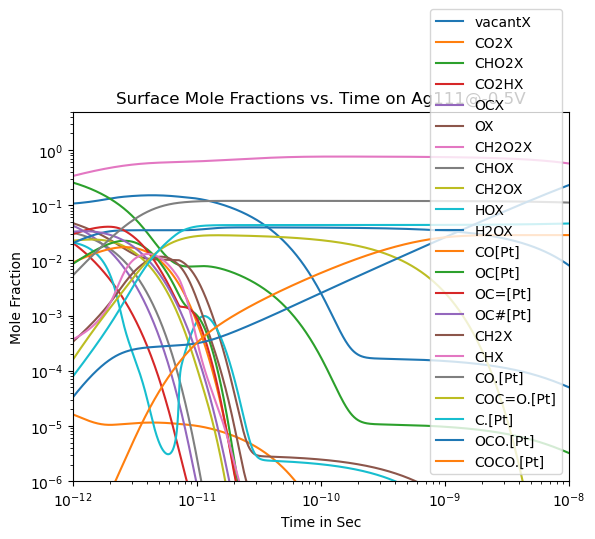

In [26]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e-8)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


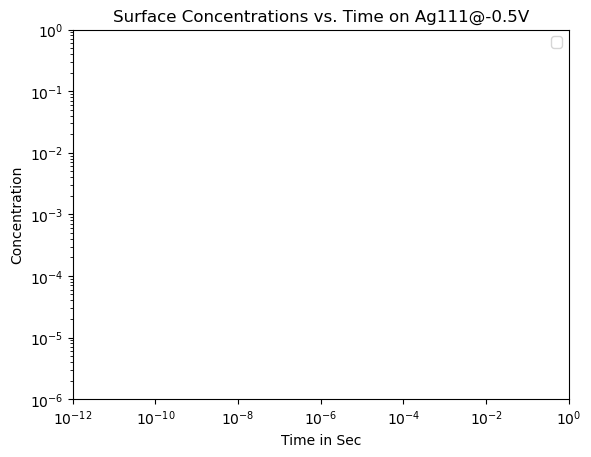

In [27]:
exclude_species = ["H2O"]
plotC(ssys.sims[2], 1e-4, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-6, 1)
title("Surface Concentrations vs. Time on Ag111@-0.5V")
gcf()

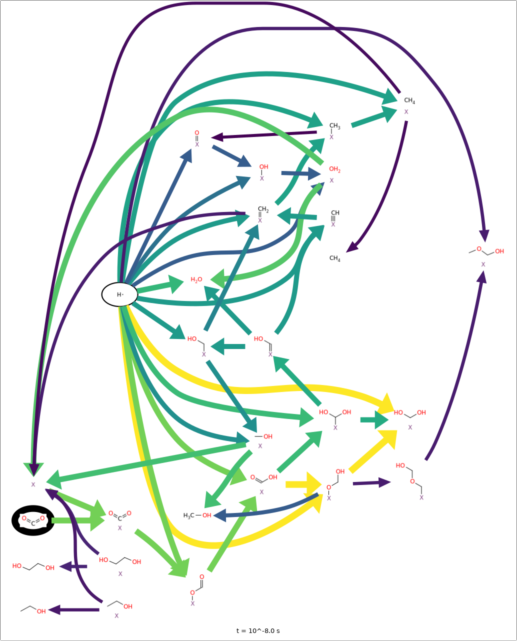

In [28]:
getfluxdiagram(ssys,1e-8;speciesratetolerance=1e-8)

In [29]:
function plotROP(ssys,name,t;N=0,tol=0.01)
    clf()
    rop = rops(ssys, name, t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    net_rops = sum(rop[inds])
    println("Net ROPs for species $name is: $net_rops")

    for (i, j) in enumerate(inds)
        println("Showing the reaction with $i th highest ROP for species $name:")
        println(getrxnstr(ssys.reactions[j]))
        println("ROP = ", rop[inds[i]])
        println(ssys.reactions[j].kinetics)
    end

    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(ssys.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    gcf()
end

plotROP (generic function with 1 method)

In [30]:
function PrintKinDetail(inter, speciesname)
    println("Showing Kinetics details for reactions involving species $speciesname\n")
    for (i,rxn) in enumerate(inter.reactions)
        flag = false
        for j = 1:length(rxn.reactants)
            if rxn.reactants[j].name == speciesname
                flag = true
            end
        end
        for j = 1:length(rxn.products)
            if rxn.products[j].name == speciesname
                flag = true
            end
        end
        if flag
            println(getrxnstr(rxn))
            println(rxn.kinetics)
            kf = inter.kfs[i]
            krev = inter.krevs[i]
            kc = kf/krev
            println("kf = $kf")
            println("krev = $krev")
            println("Kc = $kc\n")
        end
    end
end

PrintKinDetail (generic function with 1 method)

Net ROPs for species CH2O2X is: -1.9082591054747315
Showing the reaction with 1 th highest ROP for species CH2O2X:
proton+CH2O2X<=>OCO[Pt]
ROP = -2.0675635048967616
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.4999999999999992e10
  n: Float64 0.0
  Ea: Float64 92809.557203016
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CH2O2X:
proton+CHO2X<=>CH2O2X
ROP = 0.23819221798891274
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 3012.355929944578
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CH2O2X:
proton+CH2O2X<=>OC(O)[Pt]
ROP = -0.07889847999068914
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float6

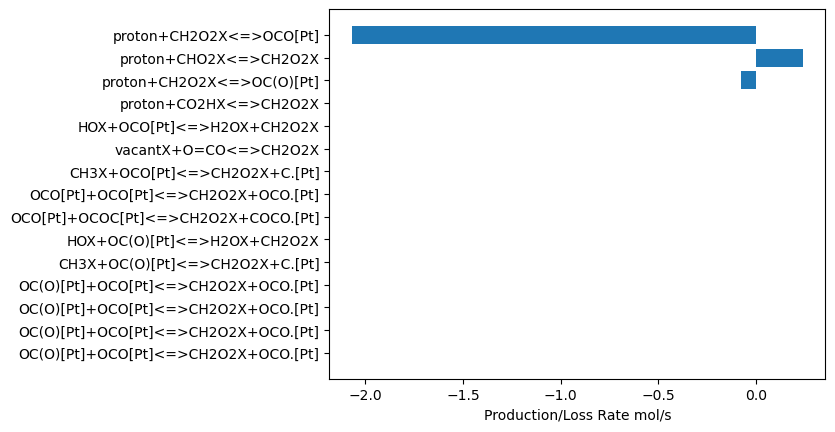

In [31]:
plotROP(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

Net ROPs for species CHO2X is: 8.711960324006833e-19
Showing the reaction with 1 th highest ROP for species CHO2X:
proton+CO2X<=>CHO2X
ROP = 5.896387390211985e-5
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e14
  n: Float64 0.0
  Ea: Float64 40225.578614126134
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CHO2X:
proton+CHO2X<=>CH2O2X
ROP = -5.896387293805412e-5
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 3012.355929944578
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CHO2X:
proton+CHO2X<=>OX+C=O
ROP = -9.372644196664853e-13
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 78620.27803454

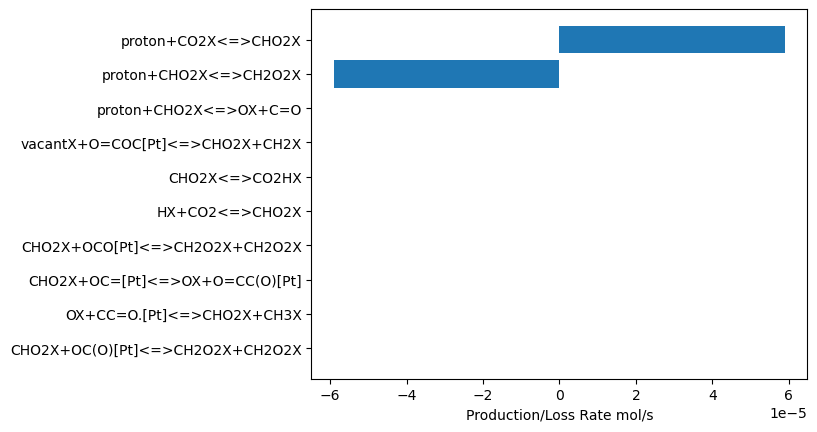

In [32]:
plotROP(ssys,"CHO2X",1;N=10,tol=0.0)

Net ROPs for species CO2HX is: 8.509291564077522e-23
Showing the reaction with 1 th highest ROP for species CO2HX:
proton+CO2X<=>CO2HX
ROP = 4.073360316506954e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 75249.98822394572
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species CO2HX:
proton+CO2HX<=>H2O+OCX
ROP = -2.036683235464772e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 28610.70853664975
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species CO2HX:
proton+CO2HX<=>CH2O2X
ROP = -2.036683235464772e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 48898.209109526

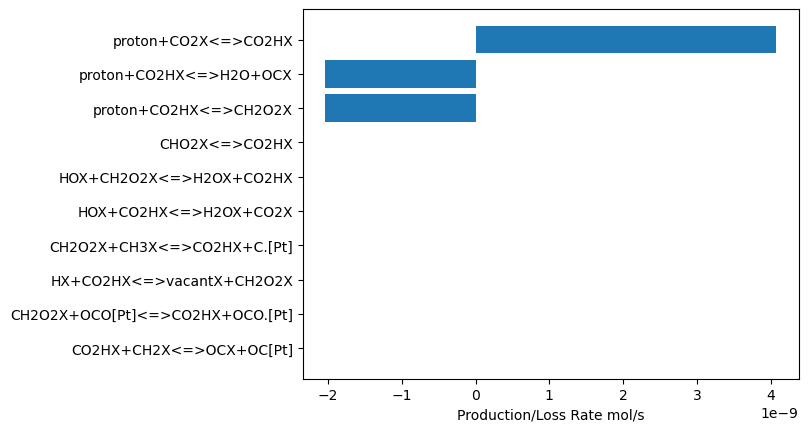

In [33]:
plotROP(ssys,"CO2HX",1;N=10,tol=0.0)

Net ROPs for species OX is: -1.2023260145092996e-18
Showing the reaction with 1 th highest ROP for species OX:
OX+proton<=>HOX
ROP = -3.997014367443517e-8
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 6012.046202225712
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OX:
proton+OCO[Pt]<=>OX+CO-2
ROP = 3.9967524626657836e-8
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 52100.05572776304
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species OX:
OX+C.[Pt]<=>HOX+CH3X
ROP = 1.6138812281280706e-12
Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 5.62e20
  n: Float64 -0.101
  Ea: Float64 98248.4989995854
  unc: EmptyRateUncertai

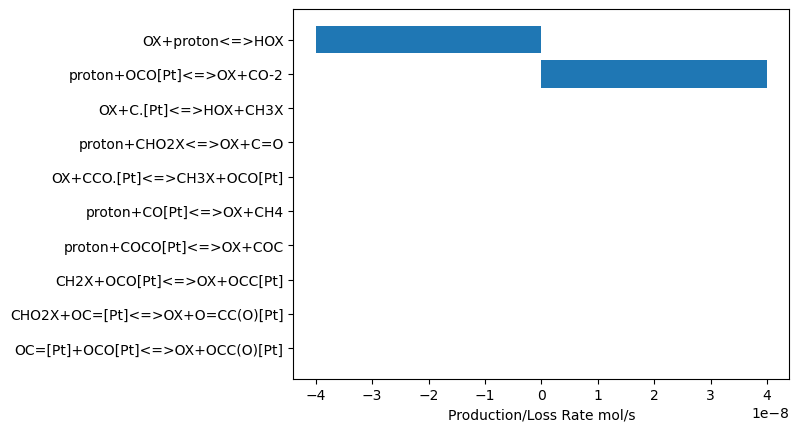

In [34]:
plotROP(ssys,"OX",1;N=10,tol=0.0)

Net ROPs for species OCX is: -6.400238860285982e-15
Showing the reaction with 1 th highest ROP for species OCX:
proton+CO2HX<=>H2O+OCX
ROP = 7.265764401581471e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 28610.70853664975
  q: Float64 0.25
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 2 th highest ROP for species OCX:
proton+OCX<=>CHOX
ROP = -3.6328855811159022e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 34575.95926752736
  q: Float64 0.5
  V0: Float64 0.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()

Showing the reaction with 3 th highest ROP for species OCX:
proton+OCX<=>OC#[Pt]
ROP = -3.6328852275222656e-9
Arrheniusq{Float64, Float64, Float64, Float64, EmptyRateUncertainty, Float64}
  A: Float64 2.5e10
  n: Float64 0.0
  Ea: Float64 42368.44859795856
  q: 

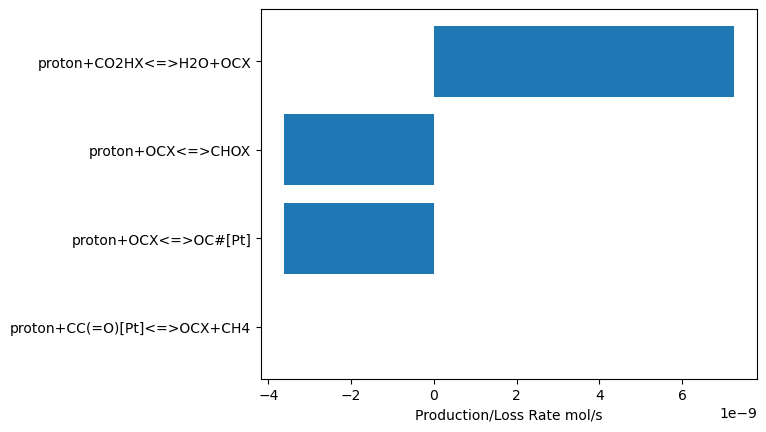

In [35]:
plotROP(ssys,"OCX",1.0e-6)

In [36]:
for (i,rxn) in enumerate(domaincat.phase.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

OX+OCX<=>vacantX+CO2X
kf = 16085.755928408827
krev = 8714.193720049168
Kc = 1.8459259049290524
CHO2X<=>CO2HX
kf = 2.1186086404854816e13
krev = 0.007560299274023117
Kc = 2.8022814490491605e15
vacantX+CHO2X<=>OX+CHOX
kf = 1.4635836812024589e9
krev = 2.7267366058988297e-15
Kc = 5.36752863491195e23
CHO2X+CHO2X<=>CO2X+CH2O2X
kf = 2.5e10
krev = 1.6770626852391395e-23
Kc = 1.490701583193066e33
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 3.2122690562069787e-15
Kc = 7.782660655928927e24
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 3.6538500611737665e-11
Kc = 6.842097946397114e20
CO2HX+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 9.719811299919681e-11
Kc = 2.5720663939439428e20
CHOX+CHO2X<=>CO2X+CH2OX
kf = 102.15331616400043
krev = 1.5667920244215681e10
Kc = 6.51990274214688e-9
CHOX+CO2HX<=>CO2X+CH2OX
kf = 2.5e10
krev = 8.754217835951314e-12
Kc = 2.8557662681560714e21
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 389487.4608035744
krev = 311.2698986694918
Kc = 1251.2853394061547
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 397.3

BoundsError: BoundsError: attempt to access 194-element Vector{Float64} at index [195]

In [37]:
for (i,rxn) in enumerate(domaincat.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

ErrorException: type ConstantTAPhiDomain has no field reactions

In [38]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 16085.755928408827
krev = 8714.193720049168
Kc = 1.8459259049290524
proton+CO2X<=>CHO2X
kf = 2.1186086404854816e13
krev = 0.007560299274023117
Kc = 2.8022814490491605e15
proton+CO2X<=>CO2HX
kf = 1.4635836812024589e9
krev = 2.7267366058988297e-15
Kc = 5.36752863491195e23
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 1.6770626852391395e-23
Kc = 1.490701583193066e33
proton+CO2HX<=>CH2O2X
kf = 2.5e10
krev = 3.2122690562069787e-15
Kc = 7.782660655928927e24
proton+OCX<=>CHOX
kf = 2.5e10
krev = 3.6538500611737665e-11
Kc = 6.842097946397114e20
proton+CHOX<=>CH2OX
kf = 2.5e10
krev = 9.719811299919681e-11
Kc = 2.5720663939439428e20
vacantX+vacantX+CO2<=>OX+OCX
kf = 102.15331616400043
krev = 1.5667920244215681e10
Kc = 6.51990274214688e-9
OX+proton<=>HOX
kf = 2.5e10
krev = 8.754217835951314e-12
Kc = 2.8557662681560714e21
vacantX+C=O<=>CH2OX
kf = 389487.4608035744
krev = 311.2698986694918
Kc = 1251.2853394061547
proton+CHO2X<=>OX+C=O
kf = 397.3892711606438
krev = 2.24174356065080

In [39]:
rops(ssys, "CH2O2X", 1e-12)

1497-element SparseArrays.SparseVector{Float64, Int64} with 174 stored entries:
  [4   ]  =  3.97519e-6
  [5   ]  =  7.29557e-12
  [6   ]  =  7.29557e-12
  [7   ]  =  1.33774e-17
  [10  ]  =  7.29557e-12
  [11  ]  =  7.29557e-12
  [13  ]  =  1.59251e-5
          ⋮
  [1246]  =  -1.37003e-23
  [1249]  =  8.81026e-14
  [1250]  =  2.21813e-12
  [1307]  =  18996.9
  [1308]  =  1526.19
  [1315]  =  -8.31654e-7
  [1332]  =  -1.22489
  [1338]  =  -0.046742

In [40]:
rops(ssys, "O=CO", 1e-12)

1497-element SparseArrays.SparseVector{Float64, Int64} with 8 stored entries:
  [1315]  =  8.31654e-7
  [1316]  =  0.00123615
  [1323]  =  4.76471e-21
  [1324]  =  -6.80261e-25
  [1334]  =  1.09758e-9
  [1336]  =  2.15383
  [1339]  =  1.24791e-8
  [1358]  =  8.43818